In [8]:
%load_ext autoreload
%autoreload 2

import torch
from timeit import default_timer
device = torch.device("cuda")
import torch.nn as nn
import numpy as np
import imageio
import matplotlib.pyplot as plt
from src.preprocessing import *
from torch.utils.data.sampler import SubsetRandomSampler
from prettytable import PrettyTable

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
data_path = "./data/"
radar_data = np.load(f'{data_path}/radars_2020-11-01_2022-12-31.npy')

actual_mask = radar_data > (abs(np.min(radar_data,axis=(1,2))).reshape(-1,1,1))
radar_data *= actual_mask
radar_data = min_max_scaller(radar_data)

glorys     = np.load(f'{data_path}/glorys_2020-11-01_2022-12-31.npy')
gfs = np.load(f'{data_path}/gfs_2020-11-01_2022-12-31.npy')
mask = load_mask(data_path+'mask.png')

idxs = get_clear_data_idxs(radar_data, zero_th_percent = 100, mask = mask)
pairs = get_idxs_pairs(idxs)

train_pairs = np.array(pairs[:int(len(pairs) * 0.7)])
valid_pairs = np.array(pairs[int(len(pairs) * 0.7):int(len(pairs) * 0.9)])
test_pairs = np.array(pairs[int(len(pairs) * 0.9):])

print('radar data : ', radar_data.shape)
print('glorys data :', glorys.shape)
print('gfs data :', gfs.shape)
print('train_pairs : ',  train_pairs.shape)
print('test_pairs :', test_pairs.shape)
print('valid_pairs :', valid_pairs.shape)

radar data :  (791, 825, 200)
glorys data : (791, 3, 825, 200)
gfs data : (791, 3, 825, 200)
train_pairs :  (127, 2)
test_pairs : (19, 2)
valid_pairs : (36, 2)


In [ ]:
i = 10
plt.subplot(1,2,1)
plt.imshow(radar_data[i])
plt.subplot(1,2,2)
plt.imshow(actual_mask[i])


In [231]:
# def generate_diff_data(radar_data, mask):
#     zeros_in_mask = np.logical_and(mask, np.logical_not(radar_data))                    # zeros-mask inside river 

#     zero_percentage = np.sum(zeros_in_mask.astype(int), (1,2)) * 100 / MASK_SUM         # zeros ratio inside river
#     filled_images_idxs = np.where(zero_percentage < 0.1)                                # idxs of fully filled images inside river

#     dataset = []                                                                        # var where we store final data

#     for fill_idx in filled_images_idxs[0]:                                              # go through all filled images
#         output_image = torch.tensor([])                                                 # difference masks with unique data 
#         input_radar = torch.tensor([])
#         used_idxs = []                                                                  # idxs of radar data that have unique data
#         filled_mask_bool = np.zeros((825, 200))                                              # mask-flag 
#         filled_mask_days = np.zeros((825, 200)) 

#         target_img = radar_data[fill_idx]                                               # target filled image that we want to predict
#         mask = np.squeeze(mask)     

#         for j in range(1,14):                                                           # 2 weeks memory
#             if fill_idx - j < 0 : break                                                 # stop if we outside the memory

#             cur_img = radar_data[fill_idx - j]                                          # past image 
#             cur_mask = np.logical_and(mask, cur_img)                                    # past image inside river
            
#             if np.sum(cur_mask) == 0:                                                   # if past image is empty inside river
#                         continue                                                        # ommit this past image

#             delta_cur = target_img - cur_img                                            # find differece between target and past image
#             delta_mask = np.logical_and(abs(delta_cur) > 1e-6, cur_mask)                # find non-zero samples mask of the difference

#             #zeros_in_deltas = np.logical_and(mask, np.logical_not(delta_mask))         
#             other_in_delats = np.logical_and(mask, delta_mask)                          # non-zero samples mask of the difference inside the river
            
#             new_data_mask = np.logical_and(np.logical_not(filled_mask_bool), other_in_delats)# select samples that has no information
            
#             if new_data_mask.astype(int).sum() != 0:                                    # if there is new info
#                 data_layer = torch.from_numpy(delta_cur * new_data_mask).unsqueeze(0)   # select difference with new info
#                 cur_radar = torch.from_numpy(cur_img * new_data_mask).unsqueeze(0)
                
#                 filled_mask_days = filled_mask_days + new_data_mask*j
#                 input_radar = torch.cat((input_radar, cur_radar), dim = 0)
#                 output_image = torch.cat((output_image, data_layer), dim = 0)           # store difference with new info
#                 used_idxs.append(fill_idx-j)                                            # store idx of data
#                 filled_mask_bool = np.logical_or(filled_mask_bool, other_in_delats)               # fill mask about having data

#         current_data = {}
#         current_data['target_idx'] = fill_idx
#         current_data['input_data'] = input_radar.sum(0).unsqueeze(0).unsqueeze(0)
#         current_data['input_idxs'] = used_idxs
#         current_data['difference'] = output_image.sum(0).unsqueeze(0).unsqueeze(0)
#         current_data['mask_days'] = torch.from_numpy(filled_mask_days).unsqueeze(0).unsqueeze(0)

#         dataset.append(current_data)

#     return dataset


In [10]:
dat = generate_simple_data(radar_data, mask)
dat.pop(59)
dataset = Simple_Dataset(dat)
batch_size = 2
validation_split = 0.2
shuffle_dataset = True 
random_seed = 42

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset: 
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_idxs , test_idxs = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idxs)
test_sampler = SubsetRandomSampler(test_idxs)

train_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = train_sampler)
test_loader  = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = test_sampler)

input_data, target_difference, days_mask, target_idx = next(iter(train_loader))

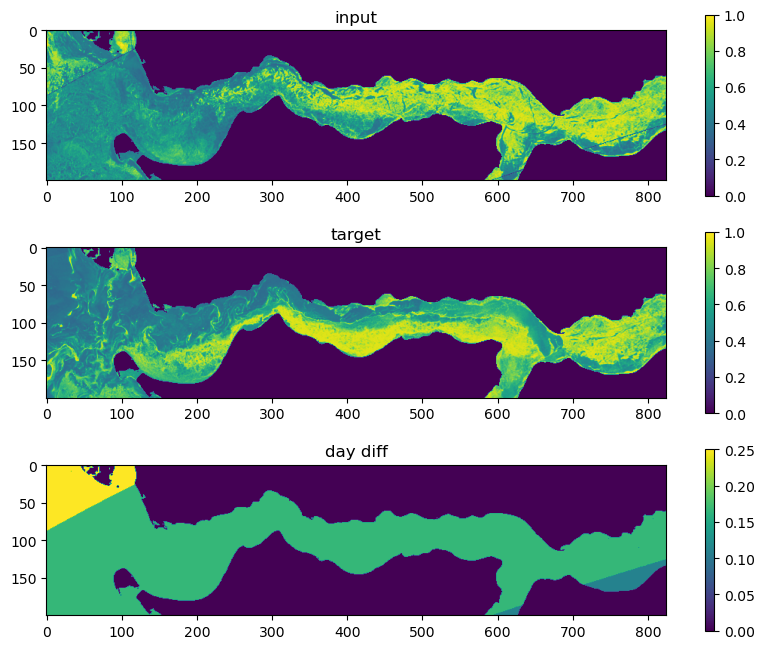

In [12]:
idx = 1
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.imshow(input_data[idx,0].T)
plt.colorbar()
plt.title('input')
plt.subplot(3,1,2)
plt.imshow(target_difference[idx,0].T);
plt.colorbar()
plt.title('target')
plt.subplot(3,1,3)
plt.imshow(days_mask[idx,0].T)
plt.title('day diff')
plt.colorbar()
plt.show()

In [68]:
from radars.UNet import UNet

model = UNet(2, 1, False, 3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)


In [69]:
def train(device, model, optimizer, trainloader, epochs=20, evalloader=False, name_experiment='model_test'):
    train_loss_list = []
    valid_loss_list = []
    grad_list = []
    
    for ep in range(epochs):
        percent_epoch  = ep/epochs
        model.train()
        t_1 = default_timer()
        train_pred_full = 0
        total_grad = 0
        for input_data, target_difference, days_mask, target_idx in trainloader:
            
            x_train = torch.cat((input_data, days_mask), dim = 1)
            y_train = target_difference
            
            l_recons = 0
            x_train = x_train.type(torch.float32).to(device)
            y_train = y_train.type(torch.float32).to(device)
            
            bs = x_train.shape[0]
            pred = model(x_train)
            loss = torch.nn.functional.mse_loss(pred.reshape(bs, -1),y_train.reshape(bs, -1) )

            train_pred_full += loss.item()

            optimizer.zero_grad()
            loss.backward()
            grad_by_batch  =  0
            for tag, value in model.named_parameters():
                if value.grad is not None:
                    grad =  value.grad.norm()
                    total_grad += grad 
                    grad_by_batch += grad

            optimizer.step()
            
        grad_list.append(total_grad.cpu().item())

        train_pred_full = train_pred_full / len(trainloader)

        train_loss_list.append(train_pred_full)

        t2 = default_timer()
        valid_pred_full = 0

        if evalloader:
            model.eval()
            with torch.no_grad():
                for input_data, target_difference, days_mask, target_idx in evalloader:

                    x_valid = torch.cat((input_data, days_mask), dim = 1)
                    y_valid = target_difference
                    
                    loss = 0
                    x_valid = x_valid.type(torch.float32).to(device)
                    y_valid = y_valid.type(torch.float32).to(device)
                    bs = x_valid.shape[0]
                    
                    pred = model(x_valid)

                    l_pred = torch.nn.functional.mse_loss(pred.reshape(bs, -1), y_valid.reshape(bs, -1))

                    valid_pred_full += l_pred.item()

            valid_pred_full = valid_pred_full / len(evalloader)

            valid_loss_list.append(valid_pred_full)

        #scheduler.step(loss)
        # scheduler.step()

        if evalloader:
            if ep == 0:
                x = PrettyTable()
                x.field_names = ["Epoch", "Time", "Train Pred MSE", "Eval Pred MSE, total grad, grad_by_batch"]
                print(x)
            if ep % 1 == 0:
                x.add_row([ep, t2 - t_1, train_pred_full, valid_pred_full, total_grad.item(), grad_by_batch.item()])
                print(x)


        #if ep % 99 == 0:
        #    torch.save(model.state_dict(), f"best_models_weights/{name_experiment}_{ep}.pth")
            
    return train_loss_list, valid_loss_list, grad_list

In [70]:
train_loss_list, valid_loss_list, grad_list = train(device, model, optimizer, 
                                         train_loader, epochs=1400, 
                                         evalloader=test_loader)



RuntimeError: stack expects each tensor to be equal size, but got [1] at entry 0 and [1, 825, 200] at entry 1